# Car Tank Leakage

A car has a tank leakage. The car is moving at constant speed v toward the mechanic shop. The air resistance is proportional to the cube of the velocity. The leakage rate is constant. Find the speed that minimizes fuel consumption and maximizes the chance of arriving at the mechanic in time before the car stops

![Car](./car.png)

The fuel consumption rate is than equal to: $$Consumption Rate = \alpha v^3 + \beta$$ 

where $\alpha$ is a constant representing the air drug coefficient and $\beta$ is a constant representing the leakage rate.

If the distance to the mechanic is equal to $d$ than the time to arrive to the mechanic is $\frac{d}{v}$ and the total fuel consumption is $$Total Consumption = (\alpha v^3 + \beta)\times(\frac{d}{v}) = d(\alpha v^2 + \frac{\beta}{v})$$

# Analytical solution

The solution is the value of $v$ that solves the equation: $$\frac{d}{dv} TotalConsumption = 0$$
since the function goes to infinity and there is only one minimum. Computing the derivative we obtain:
$$2 \alpha v - \frac{\beta}{v^2} = 0$$
$$2\alpha v = \frac{\beta}{v^2}$$
$$2\alpha v^3 = \beta$$
$$v = \sqrt[3]{\frac{\beta}{2 \alpha}}$$

# DDPG - Deep Deterministic Policy Gradient

It was first described in 2015 in the paper «Continuous control with deep reinforcement learning».
It's a Deep Reinforcement Learning method used to solve optimization problems with continuous action space.
The algorithm can be described as follows:

![DDPG1](./DDPG1.jpg)

However, in the example we are studying, there's just the present state. The action selected will not change the probability of which will be the future state, so there is no need to select a sub-optimal solution to maximize a future reward. We just have to optimize the current state. In a problem of this kind, where there is no future state (or the future state is independent of the action selected in the current state), the DDPG algorithm can be simplified as follows:

![DDPG1](./DDPG2.jpg)

The networks cooperate to find the solution to the optimization problem: the Actor and the Critic. The Actor predicts the best policy given the current state, the Critic must predict the value of the Q function given state and action.

### Let's train an agent that given $\alpha$ and $\beta$ finds the best speed to optimize fuel consumption

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tensorflow.keras.models import Sequential
from tqdm import tqdm
import cv2, json

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

C:\Users\evezzali\.conda\envs\my_env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\evezzali\.conda\envs\my_env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\evezzali\.conda\envs\my_env\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

For this problem let's say that $\alpha, \beta \in [0.1, 1.0]$. If we set the search boundary for $v$ as $[0.1, 2.0]$ the solution is always contained in the search boundary

In [3]:
num_states = 2            # Number of state variables (alpha and beta)
num_actions = 1           # Number of action variables (velocity)
upper_bound = 2.0         # Action upper bound
lower_bound = 0.1         # Action lower bound

# We define the architectures for actor and critic

In [4]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(inputs)
    out = layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(out)
    outputs = layers.Dense(num_actions, activation="sigmoid", kernel_initializer=last_init)(out)

    outputs = outputs * (upper_bound-lower_bound) + lower_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(state_input)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(concat)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

The replay buffer stores the las $n$ examples to keep in memory past examples and use them multiple times. The replay buffer is a circular buffer

In [5]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))

    # Takes (s,a,r) obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = np.squeeze(obs_tuple[0])
        self.action_buffer[index] = np.squeeze(obs_tuple[1])
        self.reward_buffer[index] = obs_tuple[2]

        self.buffer_counter += 1


    @tf.function
    def update(self, state_batch, action_batch, reward_batch):
        # Critic Training Step
        with tf.GradientTape() as tape:
            target_actions = target_actor(state_batch, training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(reward_batch - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        # Actor Training Step
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)

        self.update(state_batch, action_batch, reward_batch)


# This update target parameters slowly (weight averaging)
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

As policy we take the actions selected by the actor plus gaussian noise. Noise is used to make the agent explore the solution space. The standard deviation can be constant or can change during training (usually it gets progressively small, like in this notebook).
Noise is not applied during inference

In [6]:
def policy(state, std):
    sampled_actions = tf.squeeze(actor_model(state)).numpy()

    sampled_actions = sampled_actions + np.random.normal(0, std, sampled_actions.shape).astype('float32')

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

The reward must increase when the total consumption goes down. A function that is inversely proportional to the total consumption will do.
In particular, if we divide the total consuption by $-d$ we remove the need to know $d$.

$$Reward = -\alpha v^2 - \frac{b}{v}$$

In [7]:
def compute_reward(state, action):
    a, b = np.squeeze(state)
    v = np.squeeze(action)
    return -a*(v**2)-b/v

# Definitions

In [8]:
policy_std_dev = 0.3 #Initial Action Noise
batch_size = 128

#Actor and critics used to compute the policy during training
actor_model = get_actor()
critic_model = get_critic()

#Actual model obtained through weight averaging
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Used to update target networks
tau = 0.05

buffer = Buffer(10000, batch_size)

# Training

In [9]:
# To store reward history of each episode
reward_list = []
avg_reward_list = []

for i in range(20000):
    
    #Drag coefficient
    a = np.random.uniform(0.1, 1.0)
    #Leakage rate
    b = np.random.uniform(0.1, 1.0)
    
    state = np.array([[a,b]]).astype('float32')
    action = policy(state, policy_std_dev)
    reward = compute_reward(state, action)
    reward_list.append(reward)
    
    #Save (state, action, reward) into the replay buffer
    buffer.record((state, action, reward))
    
    #Computing a training step with a random batch taken from the replay buffer
    buffer.learn()
    update_target(target_actor.variables, actor_model.variables, tau)
    update_target(target_critic.variables, critic_model.variables, tau)
    
    # Reduce policy noise (reduces exploration, increases exploitation)
    policy_std_dev = max(policy_std_dev/(1+2e-4), 0.05)
    
    
    if (i+1)%100 == 0:
        avg_reward_list.append(np.mean(reward_list[-1000:]))
        print("Episode * {} * Avg Consumption: {}".format(str(i+1), -np.round(avg_reward_list[-1],3)))
    

Episode * 100 * Avg Consumption: 1.471
Episode * 200 * Avg Consumption: 1.819
Episode * 300 * Avg Consumption: 1.613
Episode * 400 * Avg Consumption: 1.522
Episode * 500 * Avg Consumption: 1.491
Episode * 600 * Avg Consumption: 1.453
Episode * 700 * Avg Consumption: 1.417


KeyboardInterrupt: 

# Check Results

Blue Curve: consumption per unit of distance travelled
Red Line: Predicted Solution
Green Line: Optimal Solution


<IPython.core.display.Javascript object>


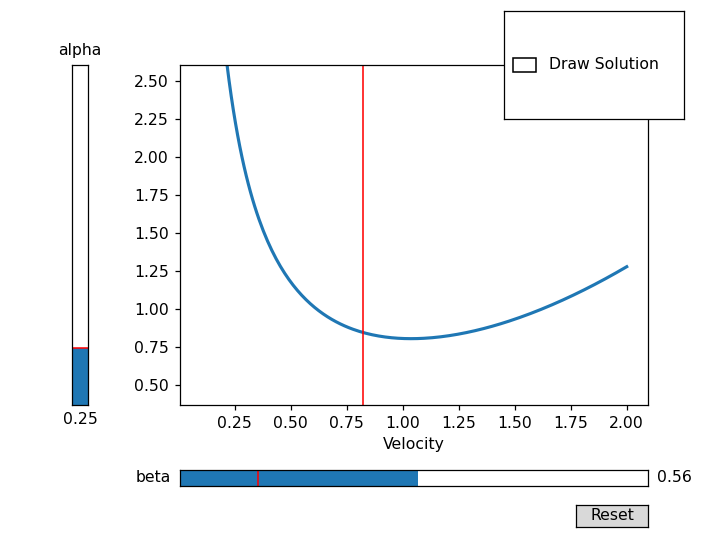

In [10]:
print('Blue Curve: consumption per unit of distance travelled')
print('Red Line: Predicted Solution')
print('Green Line: Optimal Solution')
def optimal_result(a,b):
    return np.cbrt(b/(2*a))

from matplotlib.widgets import Slider, Button, CheckButtons
%matplotlib notebook


# The parametrized function to be plotted
def f(v,a,b):
    return a*(v**2)+b/v


t = np.linspace(0.1, 2, 200)

# Define initial parameters
init_a = 0.25
init_b = 0.25
state = np.array([[init_a,init_b]]).astype('float32')
v_pred = np.squeeze(target_actor(state).numpy())
v_opt = optimal_result(init_a, init_b)

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(t, f(t, init_a, init_b), lw=2)
v_line = plt.axvline(x=v_pred, linewidth=1, color='r', label='line1')
v_line_opt = plt.axvline(x=v_opt, linewidth=1, color='g', label='line2')
v_line_opt.set_visible(not v_line_opt.get_visible())
ax.set_xlabel('Velocity')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a vertically oriented slider to control alpha
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63])
a_slider = Slider(
    ax=axamp,
    label="alpha",
    valmin=0.1,
    valmax=1,
    valinit=init_a,
    orientation="vertical"
)

# Make a horizontal slider to control the beta
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
b_slider = Slider(
    ax=axfreq,
    label='beta',
    valmin=0.1,
    valmax=1,
    valinit=init_b,
)

#Draw Checkbox
rax = plt.axes([0.7, 0.78, 0.25, 0.2])
check = CheckButtons(rax, ['Draw Solution'], [False])


# The function to be called anytime a slider's value changes
def update(val):
    
    state = np.array([[a_slider.val, b_slider.val]]).astype('float32')
    v_pred = np.squeeze(target_actor(state).numpy())
    v_opt = optimal_result(a_slider.val, b_slider.val)
    line.set_ydata(f(t, a_slider.val, b_slider.val))
    v_line.set_xdata(v_pred)
    v_line_opt.set_xdata(v_opt)
    fig.canvas.draw_idle()


# register the update function with each slider
b_slider.on_changed(update)
a_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def toggle(event):
    v_line_opt.set_visible(not v_line_opt.get_visible())
    
def reset(event):
    b_slider.reset()
    a_slider.reset()
    v_line_opt.set_visible(True)

button.on_clicked(reset)
check.on_clicked(toggle)

plt.show()